In [1]:
# --- 第1步：导入依赖库 ---
import keras
import ml_edu.experiment
import ml_edu.results
import numpy as np
import pandas as pd
import plotly.express as px

# 设置一下 Pandas 的显示格式，让小数只显示一位，看起来清爽点
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("✅ 依赖库导入成功！")

# --- 第2步：加载数据 ---
# 直接从 Google 的服务器下载这个大米数据集
print("🍚 正在下载大米数据集...")
rice_dataset_raw = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/Rice_Cammeo_Osmancik.csv")

# 筛选我们需要关注的几列特征（面积、周长、轴长等）
rice_dataset = rice_dataset_raw[[
    'Area',              # 面积
    'Perimeter',         # 周长
    'Major_Axis_Length', # 长轴长度
    'Minor_Axis_Length', # 短轴长度
    'Eccentricity',      # 离心率 (越接近1越扁，越接近0越圆)
    'Convex_Area',       # 凸包面积
    'Extent',            # 延展度
    'Class',             # 类别 (这就是我们要预测的目标：Cammeo 还是 Osmancik)
]]

print("✅ 数据集加载完成！")
print(f"总共有 {len(rice_dataset)} 粒大米的数据。")

# 看看数据长什么样
rice_dataset.head()

✅ 依赖库导入成功！
🍚 正在下载大米数据集...
✅ 数据集加载完成！
总共有 3810 粒大米的数据。


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.6,229.7,85.1,0.9,15617,0.6,Cammeo
1,14656,494.3,206.0,91.7,0.9,15072,0.6,Cammeo
2,14634,501.1,214.1,87.8,0.9,14954,0.7,Cammeo
3,13176,458.3,193.3,87.4,0.9,13368,0.6,Cammeo
4,14688,507.2,211.7,89.3,0.9,15262,0.6,Cammeo


In [2]:
# --- 第3步：数据归一化 (Normalization) ---

# 1. 计算统计数据
# .mean(): 算出每一列的平均值
# .std(): 算出每一列的标准差 (Standard Deviation)
feature_mean = rice_dataset.mean(numeric_only=True)
feature_std = rice_dataset.std(numeric_only=True)

# 2. 筛选出数字列 (因为 'Class' 列是文字，不能做减法)
numerical_features = rice_dataset.select_dtypes('number').columns

# 3. 执行 Z-Score 转换
# 这里的数学逻辑是：(原数据 - 平均值) / 标准差
# Pandas 会自动把这个计算应用到每一行、每一列
normalized_dataset = (rice_dataset[numerical_features] - feature_mean) / feature_std

# 4. 把刚才因为是文字而被扔掉的 'Class' 列再粘回来
normalized_dataset['Class'] = rice_dataset['Class']

# 看看归一化后的数据
# 你会发现 Area 变成了类似 0.5, -1.2 这种很小的数
print("✅ 数据归一化完成！")
normalized_dataset.head()

✅ 数据归一化完成！


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.5,2.0,2.3,-0.2,2.0,1.5,-1.2,Cammeo
1,1.1,1.1,1.0,0.9,0.4,1.2,-0.6,Cammeo
2,1.1,1.3,1.5,0.3,1.2,1.1,0.4,Cammeo
3,0.3,0.1,0.3,0.2,0.2,0.2,-0.3,Cammeo
4,1.2,1.5,1.3,0.5,1.0,1.3,-0.2,Cammeo


In [3]:
# --- 第4步：标签数字化 ---

# 创建一个新列 'Class_Bool'
# 逻辑：如果 Class 是 'Cammeo'，就是 True (1)；否则就是 False (0)
normalized_dataset['Class_Bool'] = (normalized_dataset['Class'] == 'Cammeo').astype(int)

# 打印 10 行看看对照关系
print("✅ 标签转换完成：Cammeo=1, Osmancik=0")
normalized_dataset.sample(10)

✅ 标签转换完成：Cammeo=1, Osmancik=0


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
3265,-1.0,-1.0,-1.0,-0.6,-0.5,-1.0,0.7,Osmancik,0
1364,1.5,1.5,1.6,0.8,1.0,1.5,-0.9,Cammeo,1
2858,-0.8,-0.8,-0.7,-0.8,-0.0,-0.8,-0.3,Osmancik,0
1431,1.0,1.3,1.8,-0.5,1.8,0.9,1.1,Cammeo,1
2351,-0.8,-0.6,-0.7,-0.7,-0.1,-0.8,-0.1,Osmancik,0
2790,-0.4,-0.5,-0.6,-0.1,-0.5,-0.4,-0.7,Osmancik,0
284,1.9,1.9,2.0,1.0,1.1,1.9,-0.6,Cammeo,1
889,-0.7,-0.4,0.0,-1.6,1.3,-0.8,-1.4,Cammeo,1
1560,1.2,1.6,1.7,0.1,1.5,1.2,-1.7,Cammeo,1
2049,-0.6,-0.5,-0.5,-0.4,-0.2,-0.6,0.1,Osmancik,0


In [ ]:
# --- 第5步：切分数据集 (Train/Validation/Test) ---

# 1. 设定切分点
number_samples = len(normalized_dataset)
index_80th = round(number_samples * 0.8)
index_90th = round(number_samples * 0.9)

# 2. 打乱数据 (非常重要！)
# random_state=100 是为了保证咱们俩打乱后的顺序是一样的，方便对答案
shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)

# 3. 切几刀
train_data = shuffled_dataset.iloc[0:index_80th]        # 前 80%
validation_data = shuffled_dataset.iloc[index_80th:index_90th] # 中间 10%
test_data = shuffled_dataset.iloc[index_90th:]          # 最后 10%

# 4. 把“题目”(Features) 和 “答案”(Labels) 分开
# 咱们不能把答案直接喂给模型，那样它就作弊了
label_columns = ['Class', 'Class_Bool']

# .to_numpy(): 把 Pandas 表格转成 Numpy 数组，因为 Keras (GPU) 更喜欢吃 Numpy 格式
train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Class_Bool'].to_numpy()

validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Class_Bool'].to_numpy()

test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Class_Bool'].to_numpy()

print("✅ 数据集切分完成！")
print(f"训练集: {len(train_features)} 条")
print(f"验证集: {len(validation_features)} 条")
print(f"测试集: {len(test_features)} 条")

✅ 数据集切分完成！
训练集: 3048 条
验证集: 381 条
测试集: 381 条


In [5]:
# --- 第6步：定义模型 (Code with Explanations) ---

def create_model(settings, metrics):
    """创建二分类模型"""
    
    # 1. 输入层：告诉模型每个特征长什么样 (都是1个数字)
    inputs = [keras.Input(shape=(1,), name=f) for f in settings.input_features]
    
    # 2. 拼接层 (Concatenate)
    # 比如我们有3个特征，这一层就把它们拼成一行 [面积, 周长, 离心率]
    concatenated = keras.layers.Concatenate()(inputs)
    
    # 3. 输出层 (★ 核心代码 ★)
    # units=1: 只需要输出一个数字 (是 Cammeo 的概率)
    # activation='sigmoid': 激活函数，把结果强行压缩到 0~1 之间
    outputs = keras.layers.Dense(units=1, activation='sigmoid', name='dense_layer')(concatenated)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # 4. 编译模型
    # loss='binary_crossentropy': 二分类专用的“评分标准”
    model.compile(optimizer=keras.optimizers.RMSprop(settings.learning_rate),
                  loss='binary_crossentropy',
                  metrics=metrics)
    
    return model

def train_model(experiment_name, model, dataset, labels, settings):
    """训练模型 (和之前差不多，只是数据格式处理了一下)"""
    
    # 把 DataFrame 转换成字典格式 { 'Area': [...], 'Perimeter': [...] }
    # Keras 喜欢这种输入格式，特别是当特征是分开定义的时候
    features = {name: np.array(value) for name, value in dataset.items()}
    
    history = model.fit(
        x=features,
        y=labels,
        batch_size=settings.batch_size,
        epochs=settings.number_epochs,
        verbose=1 # 显示进度条
    )
    
    # 打包返回结果，方便后面画图
    return ml_edu.experiment.Experiment(
        name=experiment_name,
        settings=settings,
        model=model,
        epochs=history.epoch,
        metrics_history=pd.DataFrame(history.history),
    )

print("✅ 模型定义完成！准备好进行二分类训练了。")

✅ 模型定义完成！准备好进行二分类训练了。


2026-01-13 12:57:24.800677: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2026-01-13 12:57:24.800795: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-13 12:57:24.800833: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2026-01-13 12:57:24.801324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-13 12:57:24.801723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


🚀 开始训练基准模型...
Epoch 1/60


2026-01-13 12:57:25.705403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2270 - auc: 0.1489 - loss: 1.1985
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2441 - auc: 0.1662 - loss: 1.1466
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2595 - auc: 0.1853 - loss: 1.0990
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2759 - auc: 0.2074 - loss: 1.0526
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2989 - auc: 0.2333 - loss: 1.0081
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3228 - auc: 0.2627 - loss: 0.9648
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3451 - auc: 0.2962 - loss: 0.9226
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3698 - auc: 0.3342 - loss: 0.8822
Epoch 9/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4012 - auc: 0.3764 - loss: 0.8432
Epoch 10/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4432 - auc: 0.4221 - loss: 0.8055
Epoch 11/60
31/31 ━━━━━━━━━━

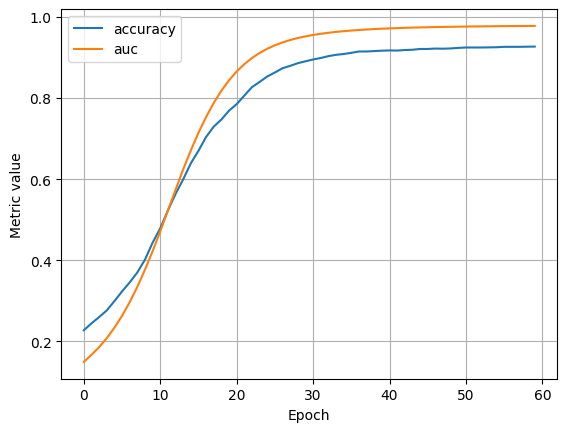

In [6]:
# --- 第7步：实验 1 (基准测试) ---

# 1. 挑选 3 个特征
input_features = ['Eccentricity', 'Major_Axis_Length', 'Area']

# 2. 设置参数
settings = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.5, # 超过 0.5 就认为是 Cammeo
    input_features=input_features,
)

# 3. 定义我们要关注的指标
# Accuracy: 准确率 (猜对的比例)
# AUC: 综合得分 (越接近 1.0 越完美)
metrics = [
    keras.metrics.BinaryAccuracy(name='accuracy', threshold=settings.classification_threshold),
    keras.metrics.AUC(name='auc'),
]

# 4. 创建并训练
print("🚀 开始训练基准模型...")
model_baseline = create_model(settings, metrics)
experiment_baseline = train_model('baseline', model_baseline, train_features, train_labels, settings)

# 5. 画图看看成绩
ml_edu.results.plot_experiment_metrics(experiment_baseline, ['accuracy', 'auc'])

In [7]:
# --- 第8步：验证集评估 (期中考试) ---

# 1. 定义一个对比函数，帮我们把两份卷子的分数打出来
def compare_train_validation(experiment, validation_features, validation_labels):
    print('📝 正在对比 [训练集] vs [验证集] 的成绩：')
    
    # 让模型去跑一下验证集数据
    val_metrics = experiment.evaluate(validation_features, validation_labels)
    
    # 打印对比结果
    print(f"训练集 Accuracy: {experiment.get_final_metric_value('accuracy'):.4f}")
    print(f"验证集 Accuracy: {val_metrics['accuracy']:.4f}")
    print("-" * 30)
    print(f"训练集 AUC:      {experiment.get_final_metric_value('auc'):.4f}")
    print(f"验证集 AUC:      {val_metrics['auc']:.4f}")

# 2. 执行评估
compare_train_validation(experiment_baseline, validation_features, validation_labels)

📝 正在对比 [训练集] vs [验证集] 的成绩：
训练集 Accuracy: 0.9272
验证集 Accuracy: 0.9029
------------------------------
训练集 AUC:      0.9781
验证集 AUC:      0.9683


🔥 火力全开：正在训练 7 特征全量模型...
Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8874 - auc: 0.9562 - loss: 0.3604
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8934 - auc: 0.9613 - loss: 0.3386
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8970 - auc: 0.9642 - loss: 0.3205
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9009 - auc: 0.9666 - loss: 0.3046
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9039 - auc: 0.9688 - loss: 0.2903
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9088 - auc: 0.9702 - loss: 0.2775
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9121 - auc: 0.9716 - loss: 0.2662
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9144 - auc: 0.9727 - loss: 0.2560
Epoch 9/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9170 - auc: 0.9736 - loss: 0.2469
Epoch 10/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9196 - auc: 0.9744 - loss: 0

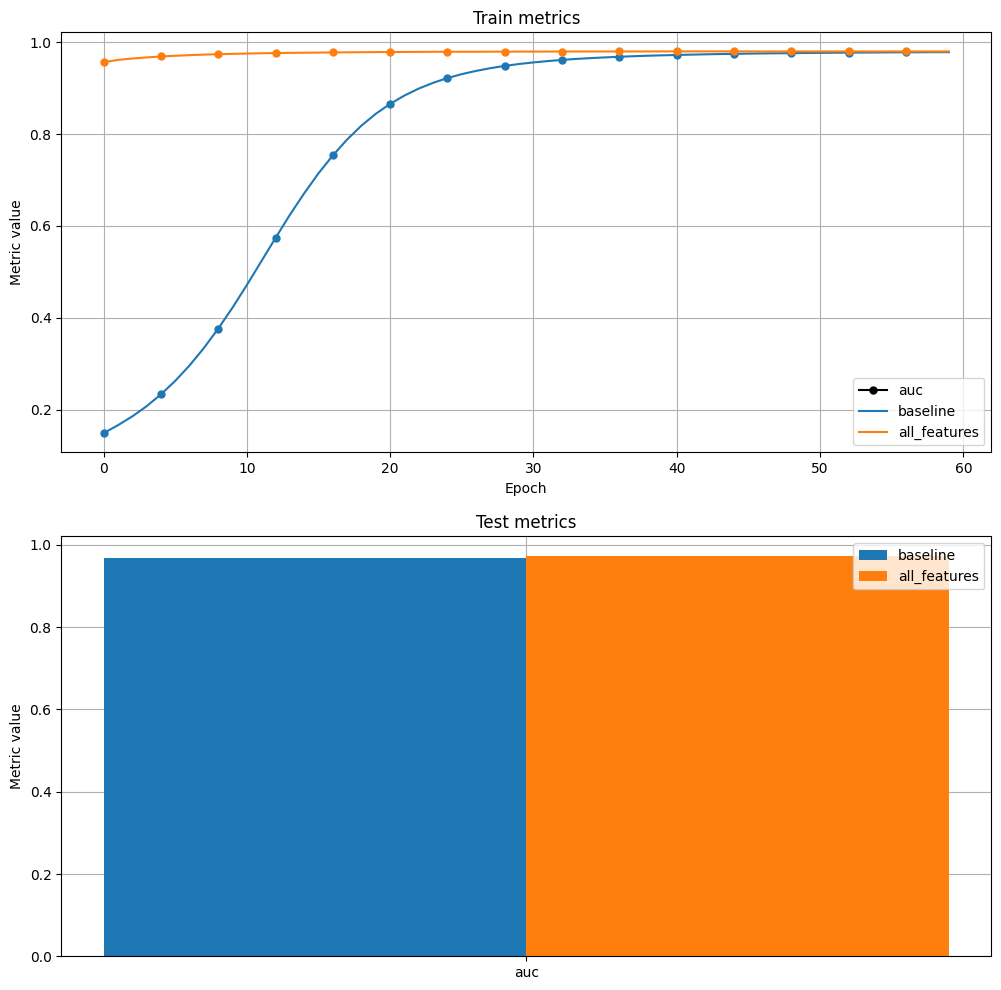

In [8]:
# --- 第9步：实验 2 (全特征挑战) ---

# 1. 这次我们要用上所有的 7 个特征
all_features = [
    'Eccentricity', 'Major_Axis_Length', 'Area', # 之前用的3个
    'Minor_Axis_Length', 'Convex_Area', 'Perimeter', 'Extent' # 新加入的4个
]

# 2. 设置新参数
settings_all = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.5,
    input_features=all_features, # <--- 注意这里换成了全特征
)

# 3. 创建并训练新模型
print("🔥 火力全开：正在训练 7 特征全量模型...")
model_all = create_model(settings_all, metrics)
experiment_all = train_model('all_features', model_all, train_features, train_labels, settings_all)

# 4. 终极PK：3特征(baseline) vs 7特征(all_features)
# 看看AUC曲线谁更高？
print("正在对比两个模型的 AUC...")
ml_edu.results.compare_experiment(
    [experiment_baseline, experiment_all], 
    ['auc'], 
    validation_features, 
    validation_labels
)

In [9]:
# --- 第10步：最终验收 (期末考试) ---

print("🎓 正在进行期末考试 (Test Set)...")

# 让那个“全特征模型”去跑测试集
test_metrics = experiment_all.evaluate(test_features, test_labels)

print("-" * 30)
print(f"最终 Accuracy: {test_metrics['accuracy']:.4f}")
print(f"最终 AUC:      {test_metrics['auc']:.4f}")

# 再次回顾一下验证集的成绩，看看有没有“翻车”
val_auc = experiment_all.get_final_metric_value('auc')
print(f"模拟考 AUC:    {val_auc:.4f}")

if abs(test_metrics['auc'] - val_auc) < 0.02:
    print("✅ 结论：发挥稳定，没有过拟合！")
else:
    print("⚠️ 结论：考场发挥失常，可能存在过拟合。")

🎓 正在进行期末考试 (Test Set)...
------------------------------
最终 Accuracy: 0.9265
最终 AUC:      0.9764
模拟考 AUC:    0.9797
✅ 结论：发挥稳定，没有过拟合！


In [10]:
# --- 补课 1：上帝视角 (3D Visualization) ---
# 我们挑出最重要的三个特征：面积、长轴、短轴
# 看看这两类大米在三维空间里是不是泾渭分明？

fig = px.scatter_3d(
    rice_dataset,           # 注意：这里我们用原始数据，而不是归一化后的，这样坐标轴有物理意义
    x='Area',               # 面积
    y='Major_Axis_Length',  # 长轴
    z='Minor_Axis_Length',  # 短轴
    color='Class',          # 按照类别上色
    opacity=0.7,            #哪怕点重叠也能看清
    title="大米分类的三维分布图 (鼠标拖拽可旋转)"
)
fig.show()

In [12]:
# %pip 能够保证安装到当前正在使用的内核里
%pip install scikit-learn seaborn

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 17.4 MB/s  0:00:00 eta 0:00:01
  Using cached https://mirrors.tuna.tsinghua.edu.cn/pypi/web/packages/ea/b1/4deb37252311c1acff7f101f6453f0440794f51b6eacb1aad4459a134081/scipy-1.15.3-cp310-cp310-macosx_14_0_arm64.whl (22.4 MB)
  Using cached https://mirrors.tuna.tsinghua.edu.cn/pypi/web/packages/7b/91/984aca2ec129e2757d1e4e3c81c3fcda9d0f85b74670a094cc443d9ee949/joblib-1.5.3-py3-none-any.whl (309 kB)
  Using cached https://mirrors.tuna.tsinghua.edu.cn/pypi/web/packages/32/d5/f9a850d79b0851d1d4ef6456097579a9005b31fea68726a4ae5f2d82ddd9/threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [seaborn]m4/5 [seaborn]earn]
Note: you may need to restart the kernel to use updated packages.


In [14]:
# --- 补课 2：更细致的体检报告 (修复版) ---
from sklearn.metrics import classification_report

# 1. 关键修复步骤：把 DataFrame 拆成字典
# 模型需要：{'Area': [...], 'Perimeter': [...], ...}
# 之前直接传 test_features 是不行的
test_input_dict = {name: np.array(test_features[name]) for name in settings_all.input_features}

print("✅ 数据格式转换完毕，正在预测...")

# 2. 现在把字典喂给模型
predictions = experiment_all.model.predict(test_input_dict)

# 3. 把概率 (0.9) 变成类别 (1)
predicted_classes = (predictions > 0.5).astype(int)

# 4. 打印报告
print("\n" + "="*60)
print("详细体检报告 (Classification Report)")
print("="*60)
print(classification_report(test_labels, predicted_classes, target_names=['Osmancik', 'Cammeo']))

✅ 数据格式转换完毕，正在预测...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

详细体检报告 (Classification Report)
              precision    recall  f1-score   support

    Osmancik       0.94      0.94      0.94       229
      Cammeo       0.91      0.90      0.91       152

    accuracy                           0.93       381
   macro avg       0.92      0.92      0.92       381
weighted avg       0.93      0.93      0.93       381



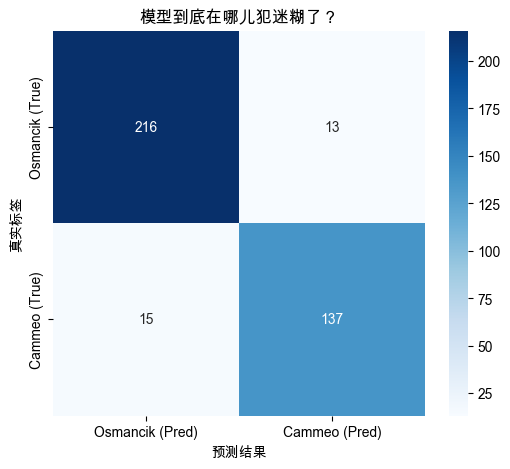

In [17]:
# --- 进阶 1：混淆矩阵 (中文乱码修复版) ---
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# 🛠️ 关键修复：告诉 matplotlib 用 Mac 自带的中文字体
# 'Arial Unicode MS' 是 Mac 上最通用的支持中文的字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False # 这一行是防止坐标轴上的负号也变乱码

# 计算混淆矩阵
cm = tf.math.confusion_matrix(test_labels, predicted_classes)

# 画图
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Osmancik (Pred)', 'Cammeo (Pred)'],
            yticklabels=['Osmancik (True)', 'Cammeo (True)'])

plt.xlabel('预测结果')
plt.ylabel('真实标签')
plt.title('模型到底在哪儿犯迷糊了？') # 现在这行字应该能正常显示了
plt.show()

In [18]:
# --- 进阶 2：自动停车系统 (Early Stopping) - 严谨修复版 ---

# 1. 必须先把数据转换成字典格式 (这是模型结构决定的，不能偷懒)
# 训练集转换
train_inputs = {name: np.array(train_features[name]) for name in settings_all.input_features}
# 验证集转换 (验证集也要转！否则监控不到)
val_inputs = {name: np.array(validation_features[name]) for name in settings_all.input_features}

# 2. 定义 Callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',         # 盯着“验证集 AUC”看
    patience=10,               # 容忍度：如果连续 10 轮都没涨分 (多给点耐心)
    restore_best_weights=True, # 停下后，自动回滚到分数最高的那一刻
    verbose=1
)

# 3. 重新创建模型
print("🚗 启动带自动刹车的训练 (数据格式已修正)...")
model_smart = create_model(settings_all, metrics)

# 4. 开始训练
history_smart = model_smart.fit(
    x=train_inputs,            # ✅ 喂字典
    y=train_labels,
    validation_data=(val_inputs, validation_labels), # ✅ 验证集也是字典
    batch_size=100,
    epochs=200,                # 故意设个很大的轮数
    callbacks=[early_stopping],# <--- 刹车片装在这里
    verbose=1
)

print(f"🏁 训练在第 {len(history_smart.epoch)} 轮自动停止了！")

🚗 启动带自动刹车的训练 (数据格式已修正)...
Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7020 - auc: 0.7802 - loss: 0.6051 - val_accuracy: 0.7034 - val_auc: 0.7702 - val_loss: 0.5820
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7244 - auc: 0.8015 - loss: 0.5594 - val_accuracy: 0.7375 - val_auc: 0.8153 - val_loss: 0.5444
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7625 - auc: 0.8431 - loss: 0.5209 - val_accuracy: 0.7743 - val_auc: 0.8482 - val_loss: 0.5104
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7897 - auc: 0.8737 - loss: 0.4859 - val_accuracy: 0.7979 - val_auc: 0.8736 - val_loss: 0.4797
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8156 - auc: 0.8974 - loss: 0.4542 - val_accuracy: 0.8215 - val_auc: 0.8924 - val_loss: 0.4520
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8333 - auc: 0.9145 - loss: 0.4256 - val_accuracy: 0.8373 - val_auc: 0.9076 - val_loss: 0.4270
Epoch 7/200
31/31 

In [19]:
# --- 进阶 3：保存你的成果 ---

# 保存刚才那个带早停功能的智能模型
# 格式推荐使用 .keras (这是 Keras 3.0 的新标准)
model_smart.save('my_rice_model.keras')

print("✅ 模型已保存为 'my_rice_model.keras'")
print("现在的它，是一个包含了所有智慧的独立文件了！")

✅ 模型已保存为 'my_rice_model.keras'
现在的它，是一个包含了所有智慧的独立文件了！
